In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib import cm
from io import StringIO
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
# from scipy.special import factorial

In [2]:
mangaid = '1-43214'
redshift = 0.117997
plateifu = '8135-1902'

In [3]:
# open the file
data = fits.open('/Users/natachaupra/Downloads/manga-8135-1902-LOGCUBE.fits.gz')

In [4]:
flux = np.transpose(data['FLUX'].data, axes=(2, 1, 0))
ivar = np.transpose(data['IVAR'].data, axes=(2, 1, 0))
mask = np.transpose(data['MASK'].data, axes=(2, 1, 0))
wave = data['WAVE'].data

do_not_use = (mask & 2**10) != 0

In [5]:
def r23(oii3727, oiii4959, oiii5007, hbeta4861):
    return (oii3727 + oiii4959 + oiii5007) / hbeta4861

In [6]:
oii3727 = np.where(np.logical_and(wave > 4150, wave < 4180))
oiii4959 = np.where(np.logical_and(wave > 5530, wave < 5555))
oiii5007 = np.where(np.logical_and(wave > 5585, wave < 5615))
hbeta4861 = np.where(np.logical_and(wave > 5400, wave < 5490))

In [7]:
# Range for x in gaussian

oii3727_range = (592, 622)
oiii4959_range = (1839, 1857)
oiii5007_range = (1882, 1904)
hbeta4861_range = (1735, 1806)

In [8]:
# Mean in gaussian

oii3727_lmd = 3727 * (1 + redshift)
oiii4959_lmd = 4959 * (1 + redshift)
oii5007_lmd = 5007 * (1 + redshift)
hbeta4861_lmd = 4861 * (1 + redshift)

In [9]:
# Initial values for amp in gaussian 

oii3727_amp = 350
oiii4959_amp = 300
oiii5007_amp = 650
hbeta4861_amp = 450

In [10]:
# Initial values for base in gaussian 

oii3727_base = 250
oiii4959_base = 150
oiii5007_base = 180
hbeta4861_base = 200

In [11]:
# Initial values for sigma in gaussian 

oii3727_sigma = 10
oiii4959_sigma = 10
oiii5007_sigma = 20
hbeta4861_sigma = 20

In [12]:
def sigma_gen_compare(array, flux_masked):
    
    # change ivar array to sigma array 
    
    sigma = np.sqrt(np.abs(np.divide(1, array, where = array != 0)))
#     print(sigma)
    
    is_less_than_3sigma = flux_masked < 3 * sigma # compare the sigma array 
#     print(flux_masked)
#     print(is_less_than_3sigma)
        
    flux_masked_filtered = flux_masked * ~is_less_than_3sigma # multiply the truth value
    
    return flux_masked_filtered

In [13]:
# gaussian = lambda x, amp, mean, sigma, base : (amp * np.exp(-(x-mean)**2 / (2*sigma**2))) + base

In [14]:
def gaussian(x, amp, mean, sigma, base):
    return (amp * np.exp(-(x-mean)**2 / (2*sigma**2))) + base

In [15]:
oiix = wave[oii3727_range[0] : oii3727_range[-1]]
# print('oiix', oiix)
# print('oiiy', oiiy)

oiiix1 = wave[oiii4959_range[0] : oiii4959_range[-1]]

oiiix2 = wave[oiii5007_range[0] : oiii5007_range[-1]]

hbetax = wave[hbeta4861_range[0] : hbeta4861_range[-1]]

In [16]:
def area_finder(x, y):
#     print('x',x)
#     print('y',y)
    dlmd = (x[-1] - x[0])/len(x)
#     print(dlmd)
        
    area = (1/2)*(dlmd)*(y[0] + y[-1] + np.sum(2*(y[1:-1])))
#     print('area', area)

    subtract = y[0] * (x[-1] - x[0])

    subtracted_area = area - subtract
#     print(subtracted_area)
    
    return subtracted_area

Change the method below to gaussian

In [34]:
to_plot = []
to_plot_wo_hbeta = []

for i in range(len(flux)):
    
    res = [] 
    res_wo_hbeta = []
    
    for j in range(len(flux[0])):

        flux_masked = flux[i,j] * ~do_not_use[i,j] # masking the array
        
        flux_masked_filtered = sigma_gen_compare(ivar[i,j], flux_masked) 
        
        oiiy = flux_masked_filtered[oii3727_range[0] : oii3727_range[-1]]
        oii_subtracted_area = area_finder(oiix, oiiy)
#         print('oii', oii_subtracted_area)

        oiiiy1 = flux_masked_filtered[oiii4959_range[0] : oiii4959_range[-1]]
        oiii1_subtracted_area = area_finder(oiiix1, oiiiy1)
#         print('oiii1', oiii1_subtracted_area)
        
        oiiiy2 = flux_masked_filtered[oiii5007_range[0] : oiii5007_range[-1]]
        oiii2_subtracted_area = area_finder(oiiix1, oiiiy2)
#         print('oiii2', oiii2_subtracted_area)
        
        hbetay = flux_masked_filtered[hbeta4861_range[0] : hbeta4861_range[-1]]
        hbeta_subtracted_area = area_finder(hbetax, hbetay)
        
        r23_wo_hbeta = (oii_subtracted_area + oiii1_subtracted_area + oiii2_subtracted_area)
        res_wo_hbeta.append(r23_wo_hbeta)
        
        if(hbeta_subtracted_area != 0):
#             print('here')
#             print(f'({i},{j})','encountered')
            r23 = (oii_subtracted_area + oiii1_subtracted_area + oiii2_subtracted_area)/hbeta_subtracted_area
            res.append(r23)
#             print(len(res), 'here')
        else:
#             print('down here')
            res.append(0)
#             print(len(res), 'down here')
            
#         print(res)
#         print(r23)
        
#         res.append(r23)
    
#     print(res)
    
    to_plot.append(res)
    to_plot_wo_hbeta.append(res_wo_hbeta)
#     print(to_plot)

In [23]:
to_plot_wo_hbeta = np.ma.masked_where(to_plot_wo_hbeta == 0, to_plot_wo_hbeta)

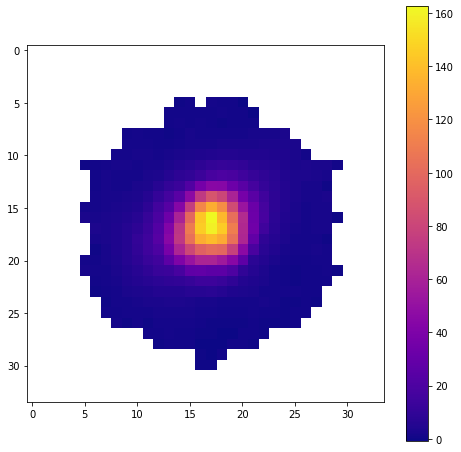

In [24]:
plt.figure(figsize = (8,8))
plt.imshow(to_plot_wo_hbeta, cmap = cm.plasma)
plt.colorbar()

In [42]:
to_plot = np.ma.masked_where(to_plot == 0, to_plot)

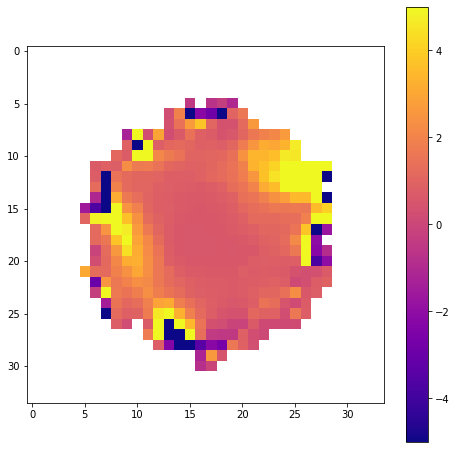

In [43]:
# print(to_plot)
plt.figure(figsize = (8,8))
plt.imshow(to_plot, cmap = cm.plasma, vmin = -5, vmax = 5)
# plt.imshow(to_plot, cmap = cm.plasma)
plt.colorbar()

In [22]:
# to_plot = []
# # for i in range(len(flux)):
    
# #     for j in range(len(flux[0])):
# for i in range(17, 20):
#     res = []
#     for j in range(17, 20):
        
#         flux_masked = flux[i,j] * ~do_not_use[i,j] # masking the array
# #         print(flux_masked)
        
#         flux_masked_filtered = sigma_gen_compare(ivar[i,j], flux_masked) # get the filtered array
        
#         # fit gaussian to the range of desired wavelength
        
#         x = wave[oii3727_range[0] : oii3727_range[-1]]
#         y = flux_masked_filtered[oii3727_range[0] : oii3727_range[-1]]
        
# #         p0 = [oii3727_amp, oii3727_lmd, oii3727_sigma, oii3727_base]
        
# #         popt_oii3727, pcov_oii3727 = curve_fit(gaussian,x, y, p0 = p0)
# #         print(popt_oii3727)
        
# #         plt.scatter(x,y)
# #         plt.plot(x, gaussian(x, *popt_oii3727))
            
#         dlmd = (x[-1] - x[0])/len(x)
        
#         area = (1/2)*(dlmd)*(y[0] + y[-1] + np.sum(2*(y[1:-1])))

#         subtract = y[0] * (x[-1] - x[0])

#         subtracted_area = area - subtract
        
        
#         res.append(subtracted_area)
# #         print('res',res)
        
#     to_plot.append(res)
# #     print('to_plot', to_plot)
    
# #         area_g = quad(gaussian, oii3727_range[0], oii3727_range[-1], args = (popt_oii3727[0],
# #                                                                            popt_oii3727[1],
# #                                                                            popt_oii3727[2],
# #                                                                            popt_oii3727[3]))


In [35]:
1/0

ZeroDivisionError: division by zero